# Estimating Proportions

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [21]:
#installing dependencies

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    
    
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

from scipy.stats import binom

import numpy as np

from empiricaldist import Pmf


## Exercises


**Exercise:** In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33.

Suppose a player appearing in their first game gets 3 hits out of 3 attempts.  What is the posterior distribution for their probability of getting a hit?


For this exercise, I'll construct the prior distribution by starting with a uniform distribution and updating it with imaginary data until it has a shape that reflects my background knowledge of batting averages.

In [22]:
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

And here is a dictionary of likelihoods, with `Y` for getting a hit and `N` for not getting a hit.

In [23]:
likelihood = {
    'Y': hypos,
    'N': 1-hypos
}

Here's a dataset that yields a reasonable prior distribution.

In [24]:
dataset = 'Y' * 25 + 'N' * 75

And here's the update with the imaginary data.

In [25]:
for data in dataset:
    prior *= likelihood[data]

prior.normalize()

1.3596964206970507e-23

Finally, here's what the prior looks like.

<AxesSubplot:>

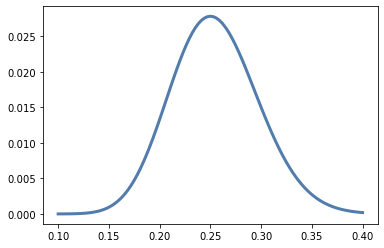

In [26]:
prior.plot(label='prior')


This distribution indicates that most players have a batting average near 250, with only a few players below 175 or above 350.  I'm not sure how accurately this prior reflects the distribution of batting averages in Major League Baseball, but it is good enough for this exercise.

Now update this distribution with the data and plot the posterior.  What is the most likely quantity in the posterior distribution?

In [27]:
#SOLUTION BEGINS HERE

data2 = 'YYY'

posterior = prior.copy()
for observation in data2:
  posterior *= likelihood[observation]

posterior.normalize()

0.017944179687707326

In [28]:
posterior.idxmax()

0.271

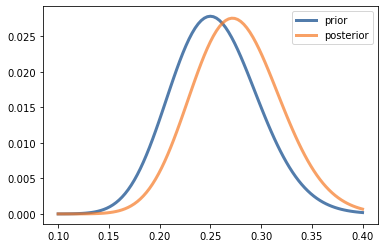

In [29]:
import matplotlib
prior.plot(label = 'prior')
posterior.plot(label = 'posterior')
matplotlib.pyplot.legend()

#SOLUTION ENDS HERE

**Exercise:** Whenever you survey people about sensitive issues, you have to deal with [social desirability bias](https://en.wikipedia.org/wiki/Social_desirability_bias), which is the tendency of people to adjust their answers to show themselves in the most positive light.
One way to improve the accuracy of the results is [randomized response](https://en.wikipedia.org/wiki/Randomized_response).

As an example, suppose you want to know how many people cheat on their taxes.
If you ask them directly, it is likely that some of the cheaters will lie.
You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,

* If they get heads, they report YES.

* If they get tails, they honestly answer the question "Do you cheat on your taxes?"

If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped heads.
Knowing this, people might be more willing to answer honestly.

Suppose you survey 100 people this way and get 80 YESes and 20 NOs.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely quantity in the posterior distribution?

In [30]:
#SOLUTION BEGINS HERE

hypos = np.linspace(0,1,101)
prior = Pmf(1, hypos)

In [31]:
likelihood = {
    'y' : 0.5*hypos + 0.5,
    'n' : 0.5*(1-hypos)
}

In [32]:
data = 'y'*80 + 'n'*20

posterior = prior.copy()

for observation in data:
  posterior *= likelihood[observation]

posterior.normalize()
posterior.idxmax()

#SOLTUON ENDS HERE

0.6

**Exercise:** Suppose you want to test whether a coin is fair, but you don't want to spin it hundreds of times.
So you make a machine that spins the coin automatically and uses computer vision to determine the outcome.

However, you discover that the machine is not always accurate.  Specifically, suppose the probability is `y=0.2` that an actual heads is reported as tails, or actual tails reported as heads.

If we spin a coin 250 times and the machine reports 140 heads, what is the posterior distribution of `x`?
What happens as you vary the value of `y`?

In [33]:
#SOLUTION BEGINS HERE

def unreliable_updating(hypos, data, failrate):
  distribution = Pmf(1, hypos)
  
  likelihood = {
      'h': (1-failrate)*hypos + failrate*(1-hypos),
      't':failrate*hypos + (1-failrate)*(1-hypos)
  }

  for observation in data:
    distribution *= likelihood[observation]

  distribution.normalize()
  return distribution

In [34]:
a = unreliable_updating(np.linspace(1,0,101),('h'*140+'t'*(250-140)),0.2)

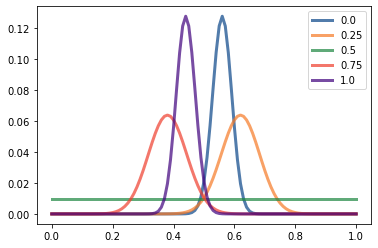

In [35]:
different_failrates = np.linspace(0,1,5)

for failrate in different_failrates:
  output = unreliable_updating(np.linspace(1,0,101),('h'*140+'t'*(250-140)),failrate)
  output.plot(label=failrate)
  matplotlib.pyplot.legend()

#SOLUTION ENDS HERE

**Exercise:** In preparation for an alien invasion, the Earth Defense League (EDL) has been working on new missiles to shoot down space invaders.  Of course, some missile designs are better than others; let's assume that each design has some probability of hitting an alien ship, `x`.

Based on previous tests, the distribution of `x` in the population of designs is approximately uniform between 0.1 and 0.4.

Now suppose the new ultra-secret Alien Blaster 9000 is being tested.  In a press conference, an EDL general reports that the new design has been tested twice, taking two shots during each test.  The results of the test are confidential, so the general won't say how many targets were hit, but they report: "The same number of targets were hit in the two tests, so we have reason to think this new design is consistent."

Is this data good or bad? 
That is, does it increase or decrease your estimate of `x` for the Alien Blaster 9000?

Hint: If the probability of hitting each target is $x$, the probability of hitting one target in both tests
is $\left[2x(1-x)\right]^2$.

<AxesSubplot:>

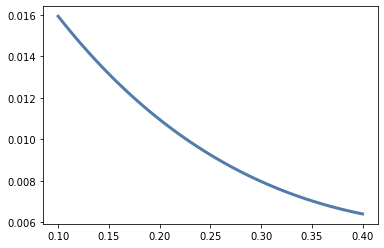

In [36]:
#SOLUTION BEGINS HERE

hypos = np.linspace(0.1, 0.4, 101)

two_shot_outcomes = [(1-hypos)*(1-hypos),(hypos)*(1-hypos),(1-hypos)*(hypos),(hypos)*(hypos)]

results = []
for outcome in two_shot_outcomes:
     prob = outcome
     result = binom.pmf(2,2,prob)
     results.append(result)

likelihood = sum(results)

prior=Pmf(1,hypos)
posterior = prior * likelihood
posterior.normalize()

posterior.plot()

#SOLUTION ENDS HERE
#For now, at least. This is close - it would certainly get us the correct answer - 
# - but not exactly correct as per Downey's solution 
# http://allendowney.github.io/ThinkBayes2/chap04.html#exercises